In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle
from copy import deepcopy

comment = "Generate simple example with fisher func"
nb_name = "nb_seqsim_simple_ex_fisher_TI_based"

# Power spectrum baseline

<IPython.core.display.Javascript object>


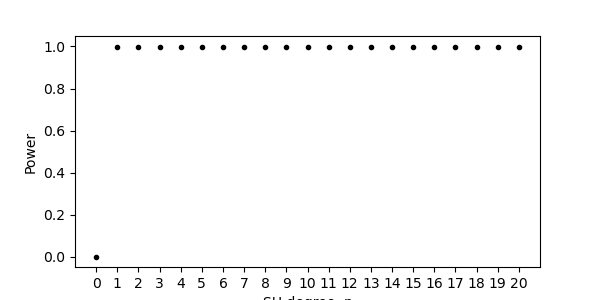

In [2]:
degrees = np.arange(1,22, dtype=float)

power = np.flip(degrees**(-1))
power = np.hstack((0,np.ones(20)))


plt.figure(figsize=(6,3))
plt.plot(power,"k.")
plt.xlabel("SH degree, n")
plt.ylabel("Power")
plt.xticks(np.arange(0,21))
plt.show()

# Surface truth

<IPython.core.display.Javascript object>


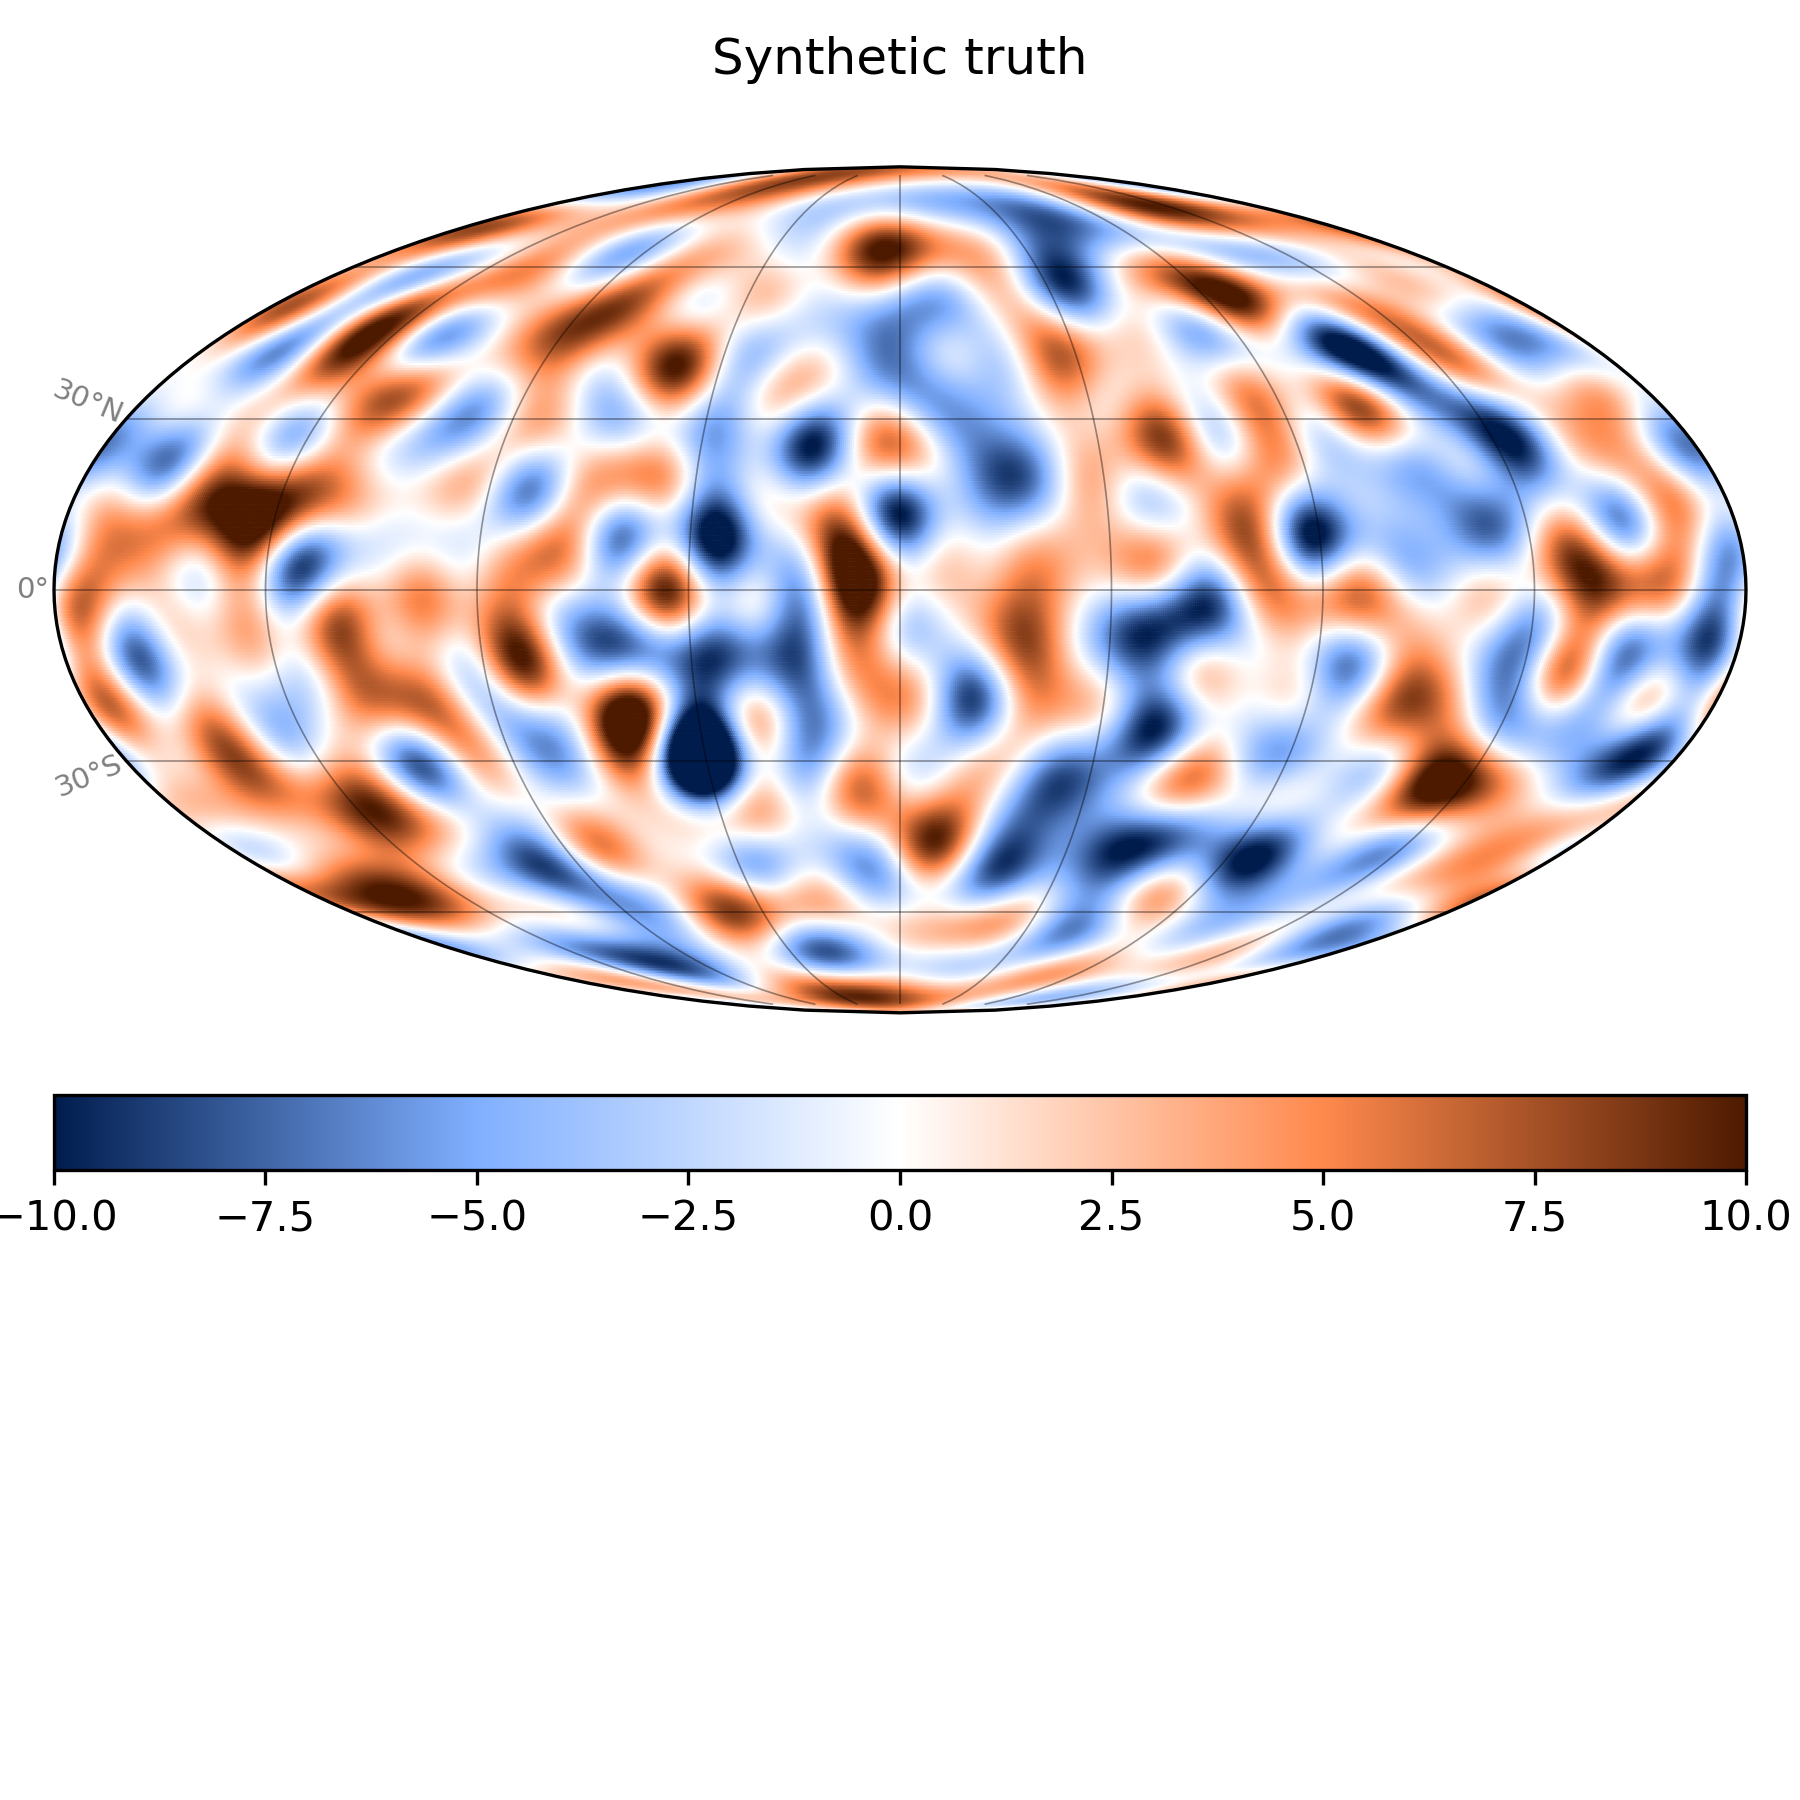

In [67]:
shn = 20
glq_r = 1

# Generate surface truth object
surface_t = SDSS(comment, N_SH = shn, sim_type = "core")
surface_t.grid_glq(nmax = shn, r_at = glq_r)
grid_in = np.array([surface_t.grid_phi, 90-surface_t.grid_theta]).T
surface_t.make_grid(glq_r, grid_in, calc_sph_d = True)

# Get random surface based on int seed
rand_int = 67803
clm = pyshtools.SHCoeffs.from_random(power, seed=rand_int)
grid = clm.expand()
coeffs = clm.to_array(lmax=shn)

# Set data from random SH coeffs
surface_t.data = pyshtools.expand.MakeGridGLQ(coeffs, surface_t.grid_zero, [surface_t.grid_nmax, 1, 1, shn, False]).reshape(-1,)
surface_t.target_var = np.var(surface_t.data)
surface_t.target_mean = 0.0
surface_t.g_prior, surface_t.g_prior_cilm = mt_util.sh_expand_glq(surface_t.data, 
                             surface_t.grid_nmax, surface_t.grid_w_shtools, surface_t.grid_zero, 
                             shn, geomag_scale = False)

# Plot surface truth
import importlib
importlib.reload(mt_util)
surface_t.grid_glq(nmax = 400, r_at = 1.0)
surface_truth = mt_util.sh_makegrid_glq(surface_t.g_prior, surface_t.grid_nmax, surface_t.grid_zero, 20)
mt_util.plot_global(lat = 90-surface_t.grid_theta, lon = surface_t.grid_phi, data=surface_truth, limits_data = [-10,10],
                title='Synthetic truth', savefig = False, save_dpi = 100, save_string ="simple_ex_fisher_truth", save_path = "images/",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, 
                rasterize = True, point_size=0.1, coast_width = 0.0)
surface_t.grid_glq(nmax = shn, r_at = glq_r)

# Surface prior

<IPython.core.display.Javascript object>


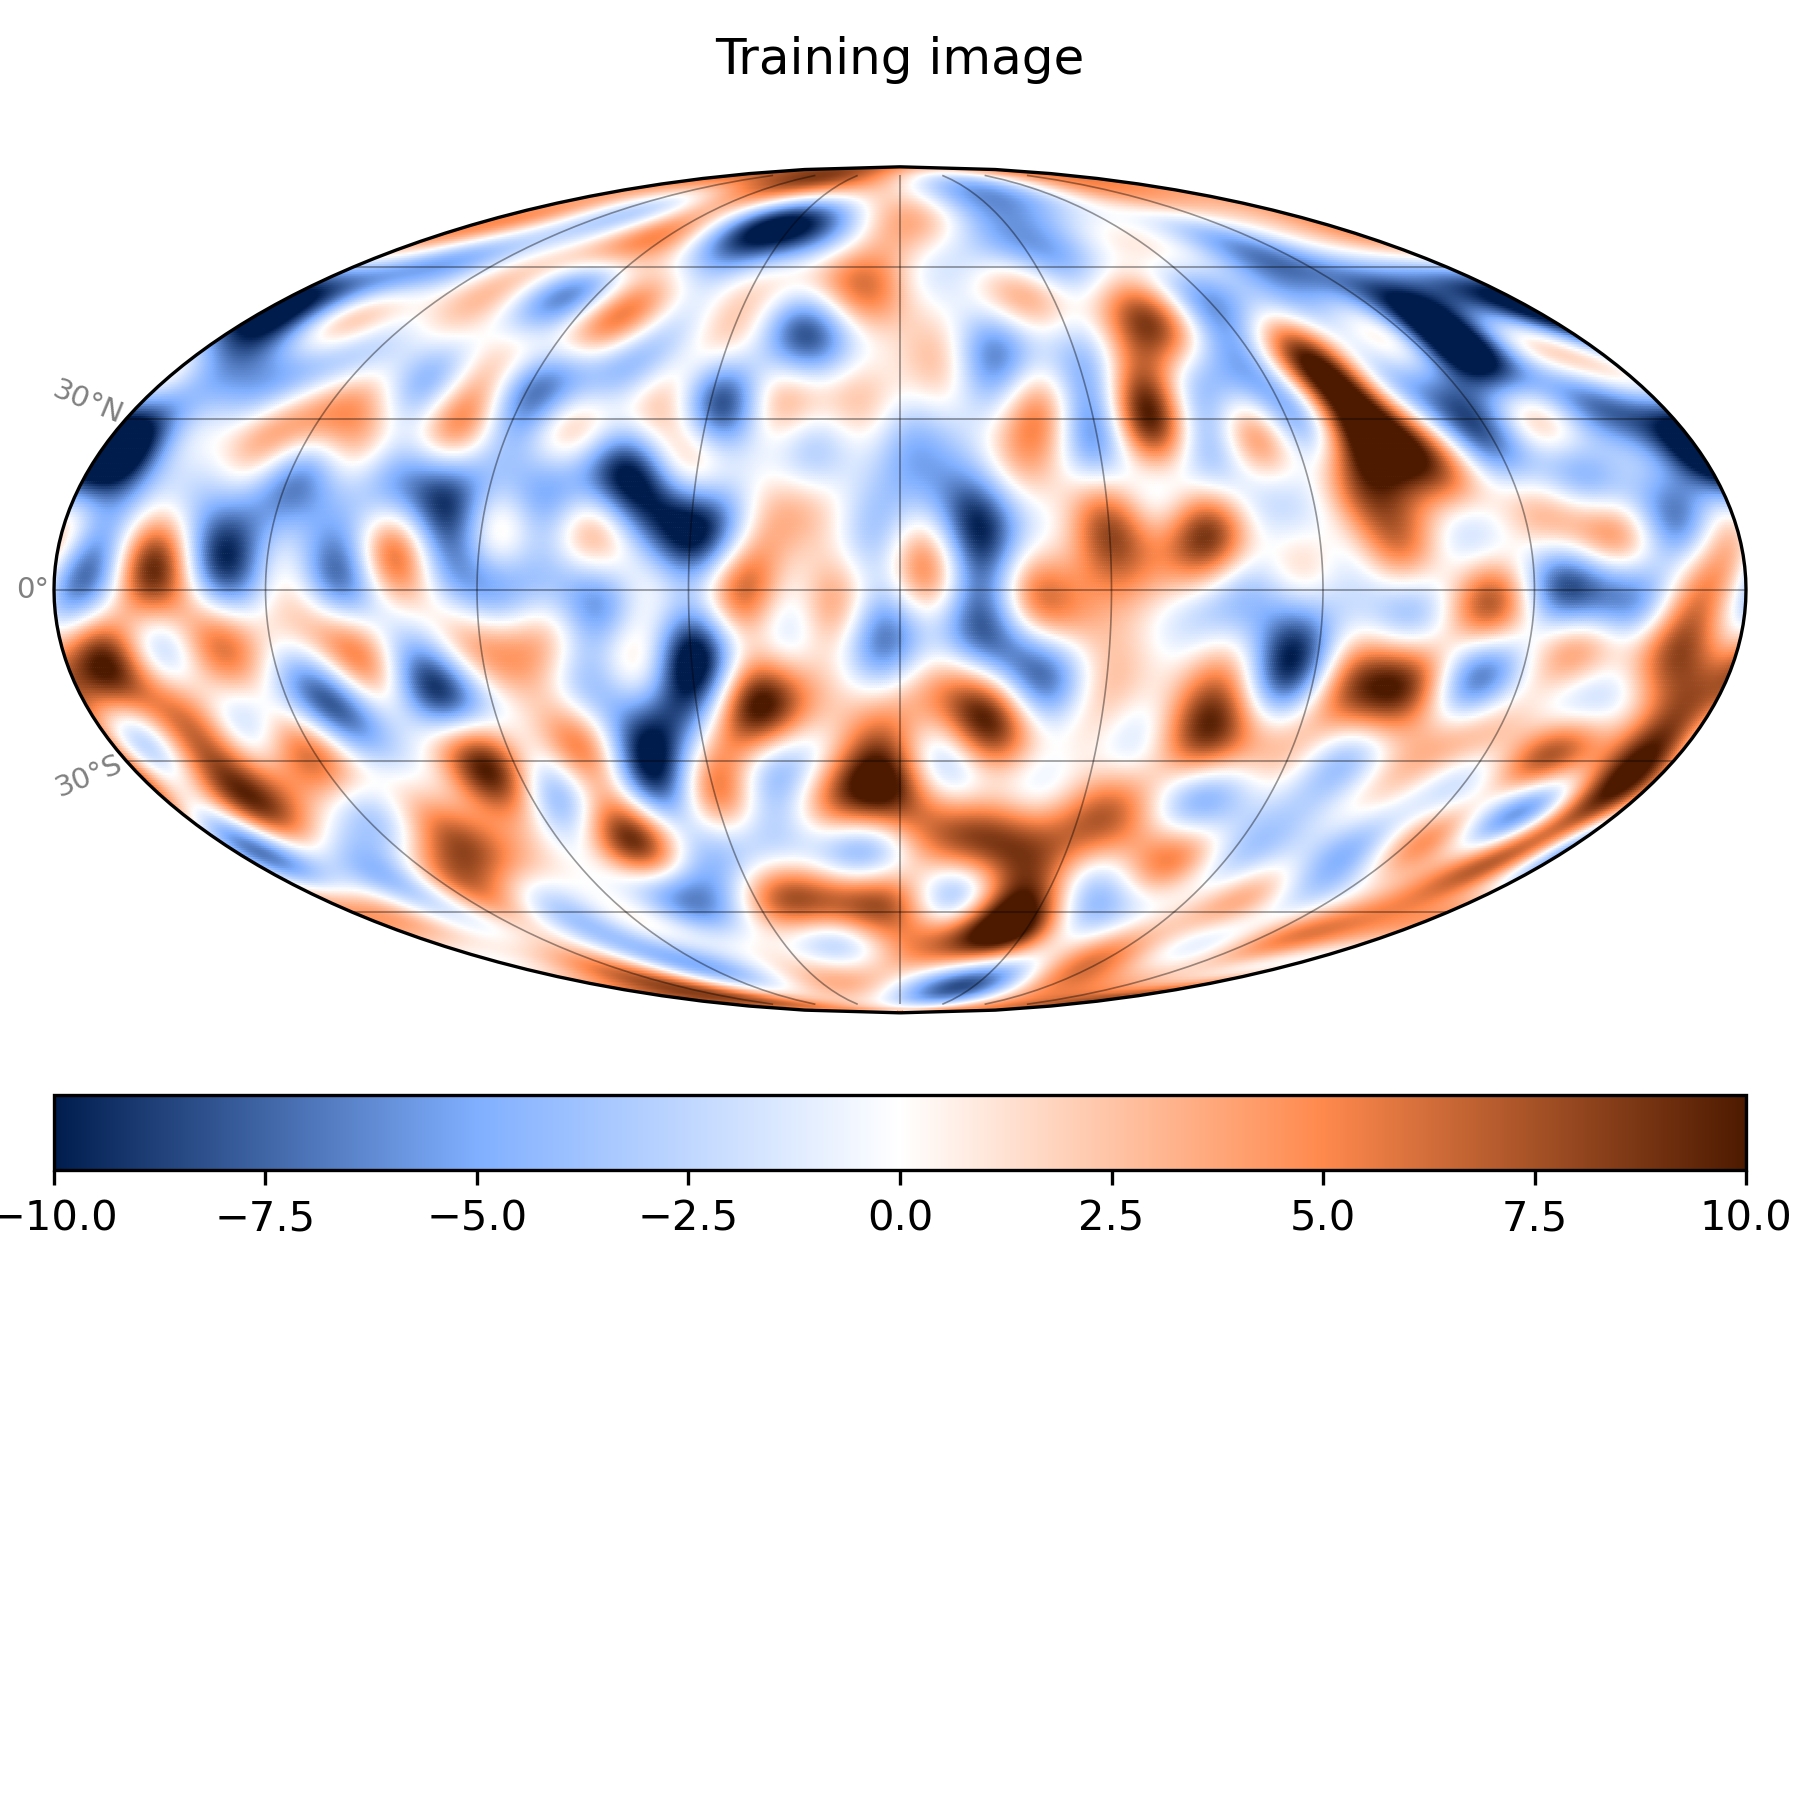

In [68]:
# Generate surface prior object
surface = SDSS(comment, N_SH = shn, sim_type = "core")
surface.grid_glq(nmax = shn, r_at = glq_r)
grid_in = np.array([surface.grid_phi, 90-surface.grid_theta]).T
surface.make_grid(glq_r, grid_in, calc_sph_d = True)

# Set up random surface based on int
rand_int = 251291
clm = pyshtools.SHCoeffs.from_random(power, seed=rand_int)
grid = clm.expand()
coeffs = clm.to_array(lmax=shn)

# Set data from random SH coeffs
surface.data = pyshtools.expand.MakeGridGLQ(coeffs, surface.grid_zero, [surface.grid_nmax, 1, 1, shn, False]).reshape(-1,)
surface.target_var = np.var(surface.data)
surface.target_mean = 0.0
surface.g_prior, surface.g_prior_cilm = mt_util.sh_expand_glq(surface.data, 
                             surface.grid_nmax, surface.grid_w_shtools, surface.grid_zero, 
                             shn, geomag_scale = False)

# Plot surface prior
import importlib
importlib.reload(mt_util)
surface.grid_glq(nmax = 400, r_at = 1.0)
training_image = mt_util.sh_makegrid_glq(surface.g_prior, surface.grid_nmax, surface.grid_zero, 20)
mt_util.plot_global(lat = 90-surface.grid_theta, lon = surface.grid_phi, data=training_image, limits_data = [-10,10],
                title='Training image', savefig = False, save_dpi = 100, save_string ="simple_ex_fisher_TI", save_path = "images/",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, 
                rasterize = True, point_size=0.1, coast_width = 0.0)
surface.grid_glq(nmax = shn, r_at = glq_r)

# Generate prior conditional dist. and semi-variogram
surface.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

surface.semivar(model_lags = "all", model = "exponential", max_dist = 20, lag_length = 0.05,
             zero_nugget = True, hit_target_var = True)

#%% PLOT SEMI-VARIOGRAM
fig = plt.figure(figsize=(10,4), dpi = 100) 
plt.plot(surface.lags,surface.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')
plt.plot(surface.lags_sv_curve,surface.sv_curve,color='C1', linewidth = 3,label='Fitted model')
plt.plot(surface.lags_sv_curve,np.ones(surface.lags_sv_curve.shape)*surface.target_var,linewidth = 3,
         color="C2", linestyle="dashed", label="Training image variance")
plt.ylabel('Semi-variance',fontsize=18,labelpad=18)
plt.xlabel('Lag',fontsize=18,labelpad=18)
plt.yticks(np.arange(0,22,2))
plt.title("Semi-variogram model of type: %s " % surface.model_names[surface.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
#fig.savefig('sv_simple_ex.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Synthetic observations

In [6]:
C_e_const = 10**(-3)

s_obs = SDSS(comment, N_SH = shn, sim_type = "random_obs")

s_obs.grid_equal_area(N_grid = 2000, r_at = 1)

grid_in = np.array([s_obs.grid_phi, 90-s_obs.grid_theta]).T
s_obs.make_grid(1, grid_in)

s_obs.r_grid = np.random.normal(loc=1.2, scale=0.05, size=(s_obs.N_grid,))


<IPython.core.display.Javascript object>


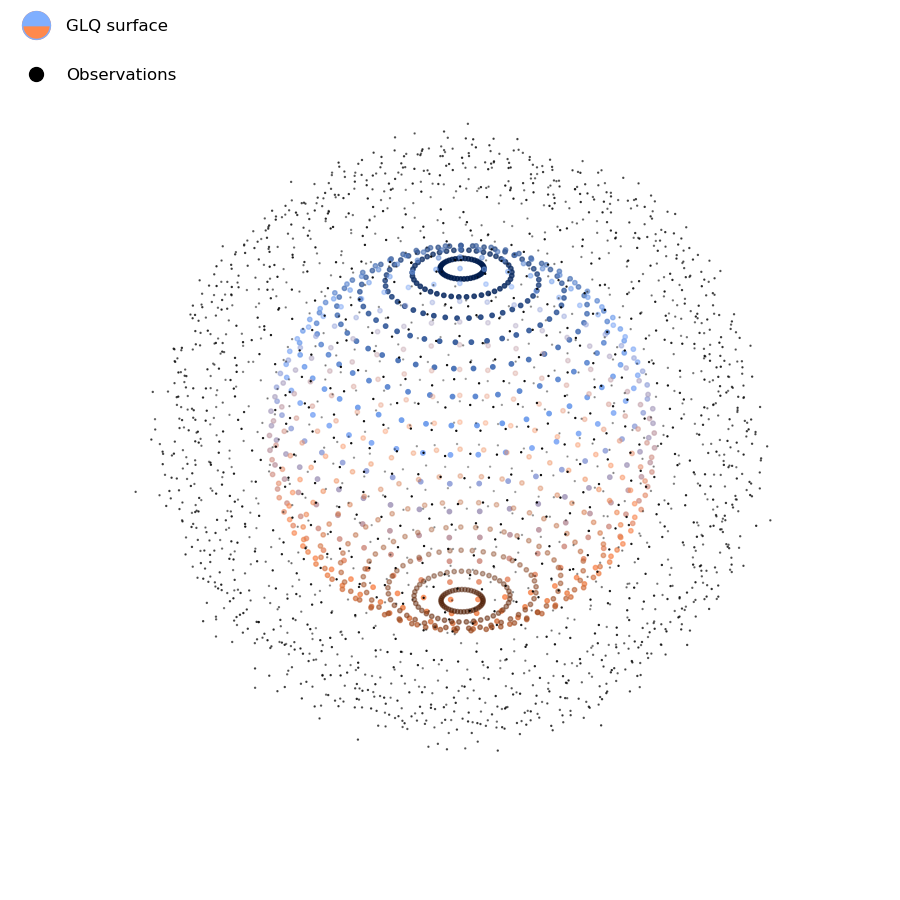

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

surface.grid_glq(nmax = shn, r_at = glq_r)
phi = surface.lon.reshape(surface.grid_nmax+1,2*surface.grid_nmax+1)*np.pi/180
theta = (90 - surface.lat.reshape(surface.grid_nmax+1,2*surface.grid_nmax+1))*np.pi/180

# The Cartesian coordinates of the unit sphere
x = 0.8*np.sin(theta) * np.cos(phi)
y = 0.8*np.sin(theta) * np.sin(phi)
z = 0.8*np.cos(theta)



#rand_size = 500
#phi_d = np.random.uniform(low = -180, high = 180.0, size = rand_size)*np.pi/180
#theta_d = np.random.uniform(low = 0, high = 180.0, size = rand_size)*np.pi/180

phi_d = s_obs.grid_phi*np.pi/180
theta_d = s_obs.grid_theta*np.pi/180

#phi_d = s_sat.lon*np.pi/180
#theta_d = (90 - s_sat.lat)*np.pi/180

#r_rand_u = np.random.uniform(low = 0.8, high = 2, size = rand_size)

r_rand_u = s_obs.r_grid

# The Cartesian coordinates of the unit sphere
x_d = r_rand_u*np.sin(theta_d) * np.cos(phi_d)
y_d = r_rand_u*np.sin(theta_d) * np.sin(phi_d)
z_d = r_rand_u*np.cos(theta_d)


cmap = [(0.0,  0.10980392156862745,  0.30196078431372547), 
                   (0.5019607843137255,  0.6862745098039216,  1.0), 
                   (1.0,  0.5372549019607843,  0.30196078431372547), 
                   (0.30196078431372547,  0.10196078431372549,  0.0)]

cmap = colors.LinearSegmentedColormap.from_list("cmap", cmap, N=1000)


fig = plt.figure(figsize=(9,9), dpi = 100, constrained_layout = True)
#ax = fig.add_subplot(111, projection='3d')

gs = fig.add_gridspec(1, 1, height_ratios=[1], width_ratios=[1]) # Add x-by-y grid
ax = fig.add_subplot(gs[0, 0], projection="3d")


sph_glq = ax.scatter(x, y, z, s = 10, cmap = cmap, c=theta, marker = "o", rasterized = True)

sph_d = ax.scatter(x_d, y_d, z_d, s = 0.5, color = "k", marker = "o", rasterized = True)

# Turn off the axis planes
ax.set_axis_off()

ax.view_init(elev=30., azim=30)
ax.set_xlim3d(-1, 1)     
ax.set_ylim3d(-1, 1) 
ax.set_zlim3d(-1, 1)

#---- Define First Legend Entry ----

m1, = ax.plot([], [], c=(0.5019607843137255,  0.6862745098039216,  1.0) , marker='o', markersize=20,
              fillstyle='top', linestyle='none')
m2, = ax.plot([], [], c=(1.0,  0.5372549019607843,  0.30196078431372547) , marker='o', markersize=20,
              fillstyle='bottom', linestyle='none')

#---- Define Second Legend Entry ----

m3, = ax.plot([], [], c='k' , marker='o', markersize=10, linestyle='none')

#---- Plot Legend ----

plt.legend(((m2, m1), (m3)), ('GLQ surface', 'Observations'), numpoints=1, labelspacing=2,
          loc='upper left', fontsize=12, frameon=False)


#fig.subplots_adjust(left=0.03, bottom=0.1, right=0.97, top=0.9, wspace = 0.0, hspace=0.0)

#fig.savefig('implementation_geometry_simple_ex.pdf', bbox_inches='tight', dpi = 300) 

#plt.legend()
plt.show()

# Fisher forward operator

<IPython.core.display.Javascript object>


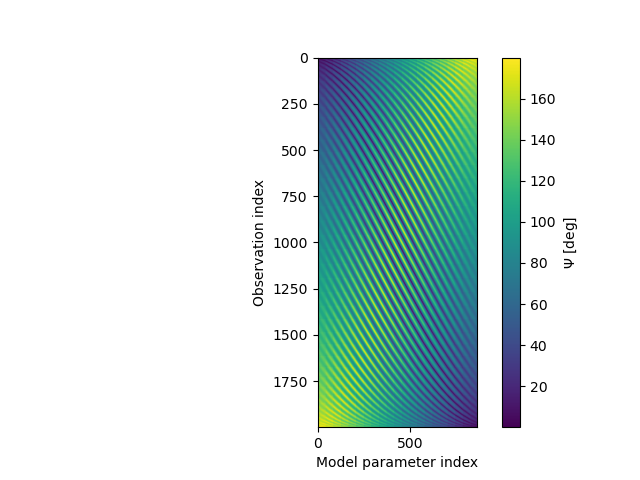

In [8]:
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [surface.grid_theta.reshape(1,-1), s_obs.grid_theta.reshape(-1,1), 
                                      surface.grid_phi.reshape(1,-1), s_obs.grid_phi.reshape(-1,1)])

angdist = np.arccos(np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s)))

plt.figure()
plt.imshow(angdist*180/np.pi)
plt.colorbar(label="$\Psi$ [deg]")
plt.xlabel("Model parameter index")
plt.ylabel("Observation index")
plt.show()

<IPython.core.display.Javascript object>


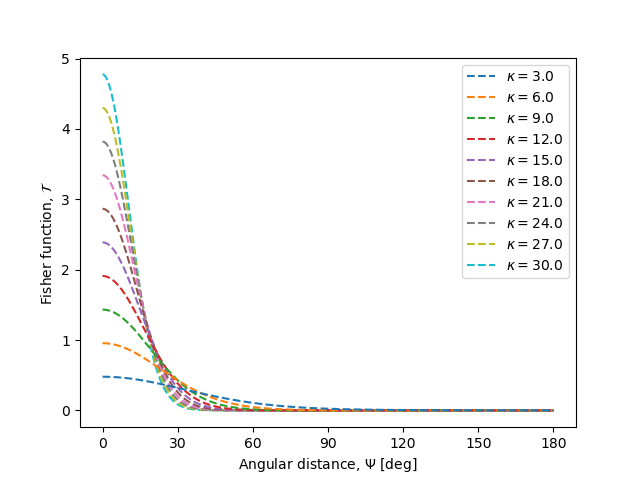

In [9]:
angdist_func = np.linspace(0,np.pi,10000)

plt.figure(dpi=100)
for kappa_func in np.linspace(3,30,10):
    kappa_func = np.round(kappa_func)
    Tau_func = kappa_func/(4*np.pi*np.sinh(kappa_func))*np.exp(kappa_func*np.cos(angdist_func))
    plt.plot(angdist_func*180/np.pi,Tau_func, label = "$\kappa = ${}".format(kappa_func),zorder=1/kappa_func,linestyle="dashed")
plt.xlabel("Angular distance, $\Psi$ [deg]")
plt.ylabel("Fisher function, $\mathcal{T}$")
plt.xticks(np.arange(0,180+30,step=30))
plt.legend()
#plt.savefig('fisher_kappas.pdf', bbox_inches='tight', dpi = 300) 
plt.show()

<IPython.core.display.Javascript object>


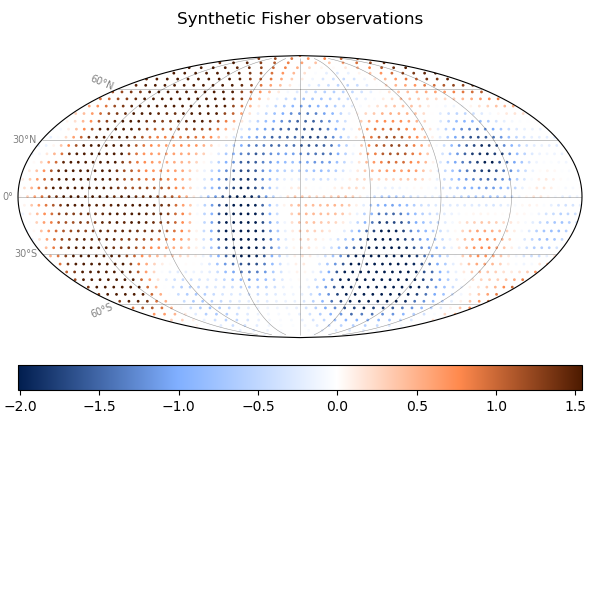

In [10]:
kappa = 15
Tau = 1/s_obs.r_grid.reshape(-1,1)*kappa/(4*np.pi*np.sinh(kappa))*np.exp(kappa*np.cos(angdist))
Tau.shape

# Generate forward operator and covariances based on prior object
surface.G = np.pi/(surface.grid_nmax+0.5)*np.multiply(surface.grid_w,Tau) # +0.5 for parity with SHTOOLS

C_e = np.diag(C_e_const**2*np.ones(s_obs.N_grid,)) # No need to store C_e outside of here

surface.C_mm_all = surface.target_var-surface.sv_lut

surface.C_dm_all = surface.G@surface.C_mm_all

surface.C_dd = surface.C_dm_all@surface.G.T  + C_e

surface.C_dm_all = surface.C_dm_all.T

surface.C_e_const = C_e_const


# Use forward operator to generate synthetic truth observations based on synthetic truth object
s_obs.data = surface.G@surface_t.data
s_obs.data += np.random.normal(scale = C_e_const, size = s_obs.data.shape)

# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

mt_util.plot_global(lat = s_obs.lat, lon = s_obs.lon, data=s_obs.data, 
                cbar_h = 0.075, cbar_even = False, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(6,6), coast_width = 0.0,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Synthetic Fisher observations', point_size=1,
                savefig = False, save_dpi = 100, save_string ="simple_ex_fischer_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# Unconditional simulation

In [19]:
surface_uncon = deepcopy(surface)

 |O---------| 19.7%   realization nr. 0. Counter: 170/861, Running error magnitude: 0.4

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 861/861, Running error magnitude: 0.5
Run time: 4.886 seconds 
Total elapsed time: 0.081 minutes 
Variance: 15.186
Mean: -0.367
Max: 12.290
Min: -14.717
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 861/861, Running error magnitude: 0.5
Run time: 5.370 seconds 
Total elapsed time: 0.171 minutes 
Variance: 17.672
Mean: -1.311
Max: 9.485
Min: -14.999
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 861/861, Running error magnitude: 0.5
Run time: 5.430 seconds 
Total elapsed time: 0.261 minutes 
Variance: 19.847
Mean: -0.990
Max: 12.100
Min: -14.398
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 861/861, Running error magnitude: 0.5
Run time: 6.124 seconds 
Total elapsed time: 0.363 minutes 
Variance: 19.956
Mean: -0.397
Max: 12.832
Min: -15.137
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 861/861, Running error magnitude: 0.5
Run time: 5.167 seconds 
Total elapsed time: 0.4

<IPython.core.display.Javascript object>


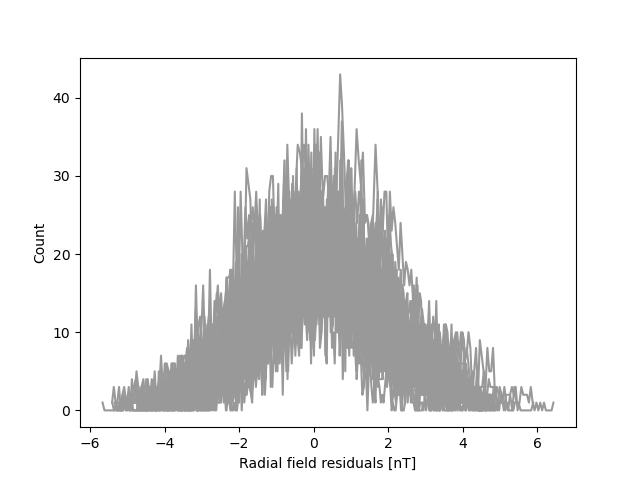

In [46]:
N_sim = 30

surface_uncon.run_sim(N_sim, surface_uncon.grid_N, surface_uncon.C_mm_all, surface_uncon.C_dd,
        surface_uncon.C_dm_all, surface_uncon.G,
        s_obs.data, surface_uncon.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho=True)

In [47]:
surface_uncon.realization_to_sh_coeff(1, set_nmax = shn, geomag_scale = False)

# Conditional simulation

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.264 minutes 
Total elapsed time: 2.264 minutes 
Variance: 18.900
Mean: 0.242
Max: 12.613
Min: -14.663
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.137 minutes 
Total elapsed time: 4.401 minutes 
Variance: 18.390
Mean: 0.248
Max: 16.327
Min: -13.099
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.148 minutes 
Total elapsed time: 6.549 minutes 
Variance: 19.192
Mean: 0.252
Max: 14.207
Min: -15.009
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.164 minutes 
Total elapsed time: 8.713 minutes 
Variance: 19.122
Mean: 0.254
Max: 12.481
Min: -16.205
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.185 minutes 
Total elapsed time: 10.897

<IPython.core.display.Javascript object>


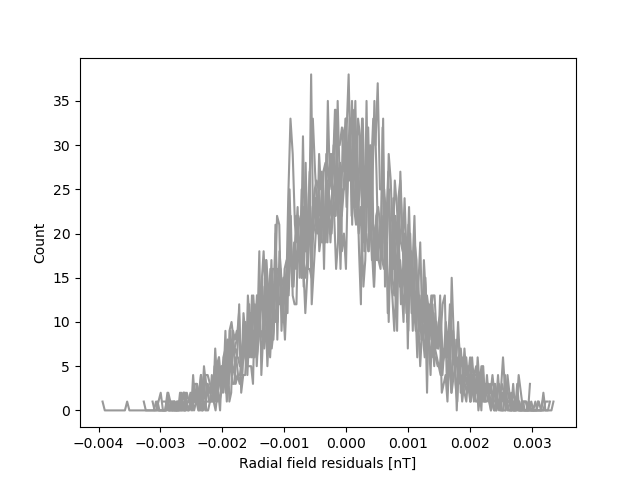

In [22]:
N_sim = 6

surface.run_sim(N_sim, surface.grid_N, surface.C_mm_all, surface.C_dd, surface.C_dm_all, surface.G,
        s_obs.data, surface.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho=True)

In [23]:
surface.realization_to_sh_coeff(1, set_nmax = shn, geomag_scale = False)

In [24]:
surface.covmod_lsq_equiv(s_obs.data, surface.C_mm_all, surface.G, 1.0, geomag_scale = False)

<IPython.core.display.Javascript object>


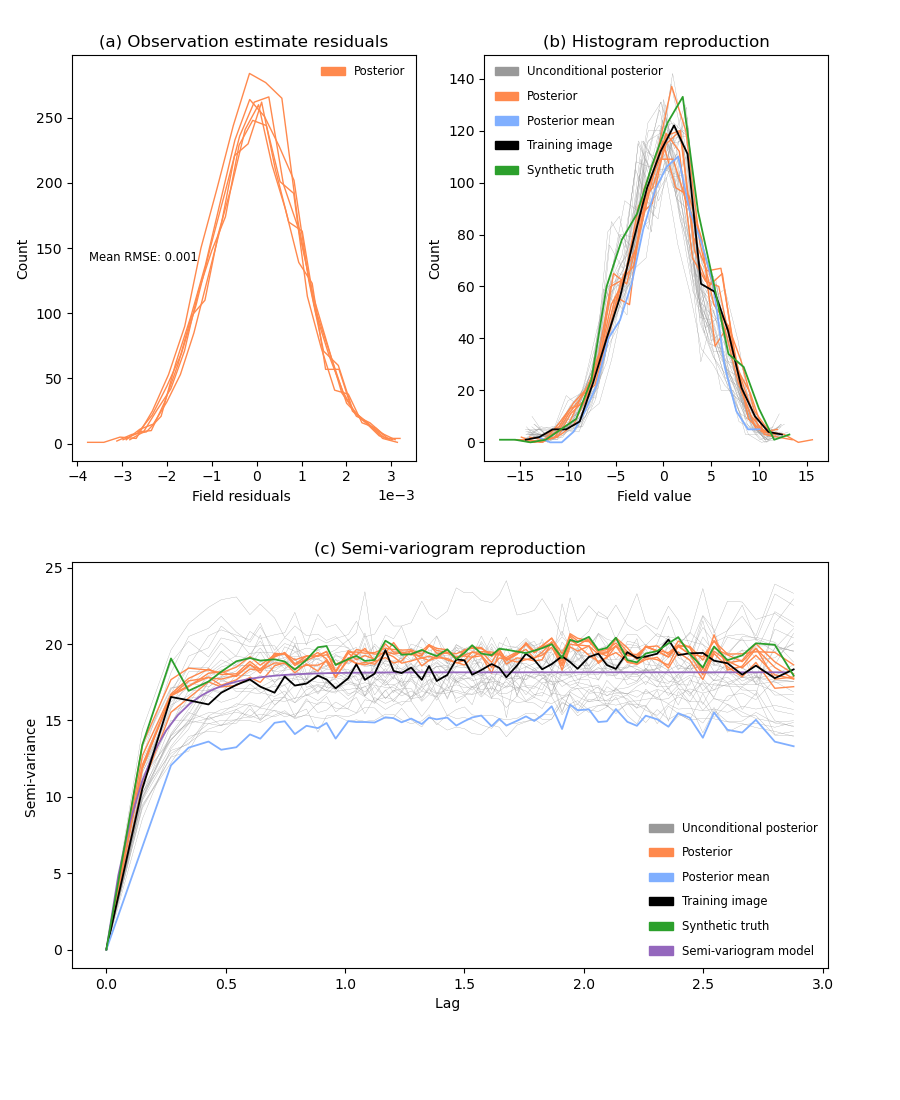

In [66]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

surface.grid_glq(nmax = shn, r_at = 1.0)
#surface.m_equiv_lsq
mt_util.plot_sdssim_reproduce(surface, surface.m_DSS_res, m_equiv_lsq = None,
                              lwidth = 1, lwidth_mult = 1.3, lwidth_div=5,
                              truth_obj = surface_t, uncon_obj = surface_uncon,
                              spec_r_at = 1.0, spec_use = False, spec_show_differences = False, spec_mag = False,
                              figsize=(9,11), hist_pos_mean = True, sv_pos_mean = True, lags_use = 1000,
                              unit_var = "", unit_lag = "", unit_field = "", unit_res = "",
                              hist_bins = 20, res_bins = 20, patch_legend = True,
                              res_power_format = True, power_limit = -3, res_print_f = 3,
                              savefig = True, save_string = "simple_ex_fisher", save_path = "images/", save_dpi = 300)

In [51]:
set_nmax = shn
r_at = 1.0

surface.grid_glq(nmax = 400, r_at = r_at)

# Posterior
zs_eqa = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface.g_spec[:,i], surface.grid_nmax, surface.grid_zero, set_nmax)
    
    zs_eqa.append(z_grid.reshape(-1,))
zs_eqa = np.array(zs_eqa).T

# Unconditional posterior
zs_uncon = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface_uncon.g_spec[:,i], surface.grid_nmax, surface.grid_zero, set_nmax)
    
    zs_uncon.append(z_grid.reshape(-1,))
zs_uncon = np.array(zs_uncon).T

# Posterior mean
zs_mean_eqa = mt_util.sh_makegrid_glq(surface.g_spec_mean, surface.grid_nmax, surface.grid_zero, set_nmax)

# Truth
prior_eqa = mt_util.sh_makegrid_glq(surface_t.g_prior[:mt_util.shc_vec_len(set_nmax)], surface.grid_nmax, surface.grid_zero, set_nmax)

# LSQ
lsq_eqa = mt_util.sh_makegrid_glq(surface.g_equiv_lsq, surface.grid_nmax, surface.grid_zero, set_nmax)

<IPython.core.display.Javascript object>


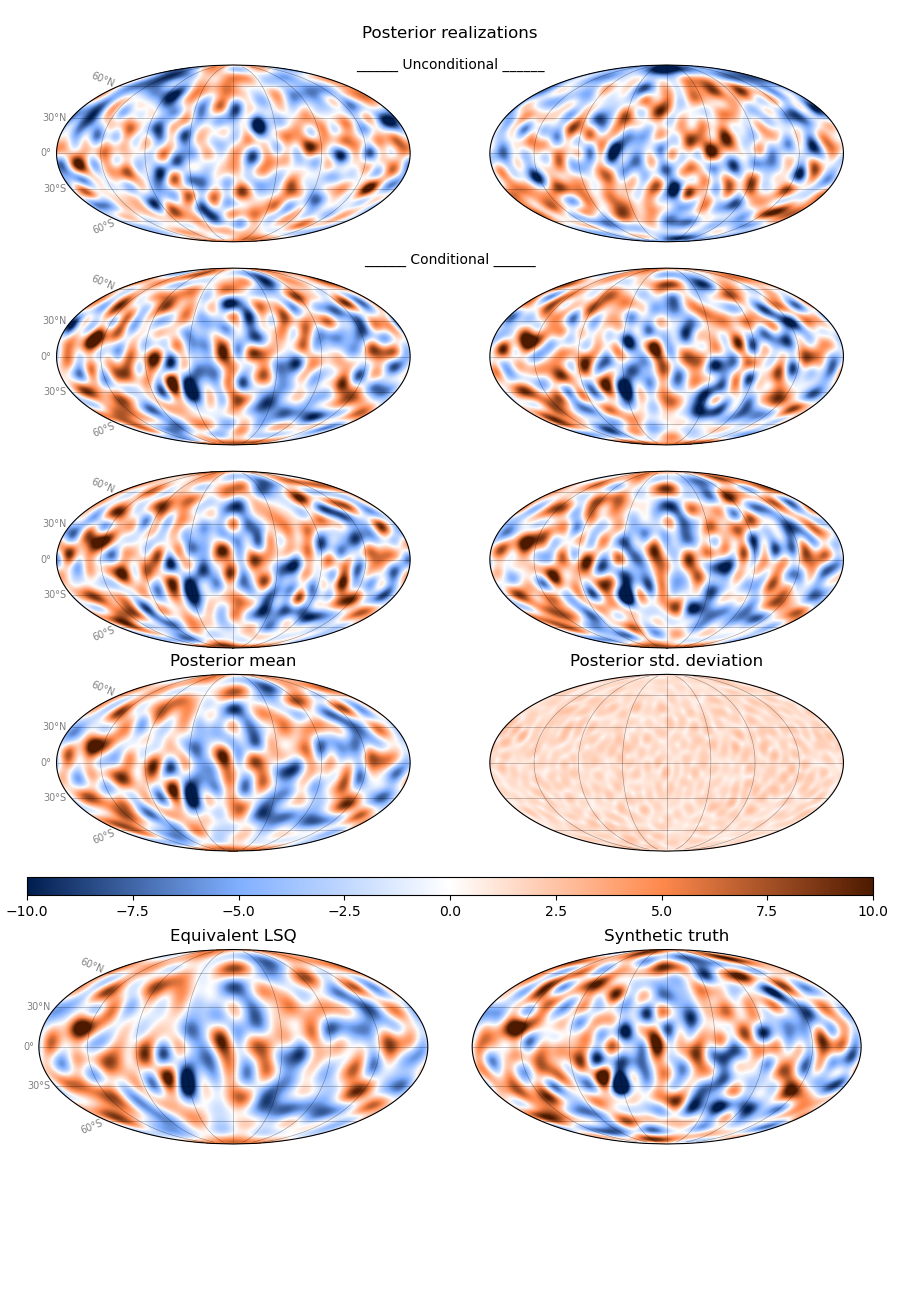

In [64]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(surface.grid_phi, 90-surface.grid_theta, zs_eqa, field_uncon = zs_uncon,
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,13), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1,
                        coast_width = 0.0, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "", cbar_text_color = "black", cbar_limit = [-10,10],
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "simple_ex_fisher", save_path = "images/",
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


In [28]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")